Get correlations between replicates over titrations

In [1]:
# python modules
import sys
import copy
import re
import random
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats

In [2]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}

agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}

agent_charge = {'sp':'4+',
                'spd':'3+',
                'CoH':'3+',
                'PEG':'',
                'Ca':'2+',
                'Mg':'2+',
                'HP1a':'',
                'HP1bSUV':'',
                'LKH':'',
                'Ki67':'',
                'FUS':''}

In [5]:
### load gtab files
gtab_path = "/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/"
dinfo_dkey = {'GM_synNCP_sp_1rep_10kb_score.gtab.gz':{},
              'GM_synNCP_sp_2rep_10kb_score.gtab.gz':{},
              }

dkey_ID_score = load_file.read_gtab_batch (dinfo_dkey,
                                           data_path=gtab_path)


loading GM_synNCP_sp_1rep_10kb_score.gtab.gz


loading GM_synNCP_sp_2rep_10kb_score.gtab.gz


Done


In [6]:
### group dkeys by experiment and corresponding tnums
dexp_tnums = {}
for dkey in dkey_ID_score:
    cell, sample, agent, tnum, rep = dkey.split('_')
    if rep == '2rep':
        continue
    dexp = (cell, sample, agent)
    tnum = int(tnum)
    if dexp not in dexp_tnums:
        dexp_tnums[dexp] = []
    dexp_tnums[dexp].append(tnum)

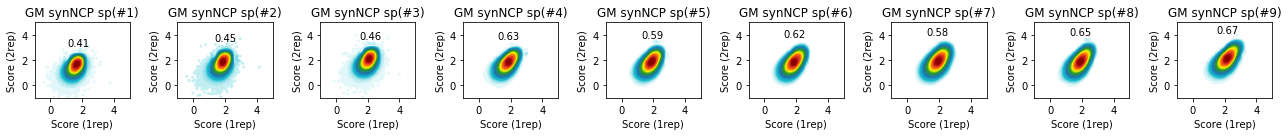

In [7]:
### check the correation between replicates over titrations
for dexp in sorted(dexp_tnums):
    cell, sample, agent = dexp
    tnums = sorted(dexp_tnums[dexp])

    fig_width = 2*len(tnums)
    fig_height = 2

    fig, axes = plt.subplots(nrows=1,
                             ncols=len(tnums),
                             figsize=(fig_width, fig_height))

    if len(tnums) == 1:
        axes = [axes]
    
    for i in range(len(tnums)):
        tnum = tnums[i]
        dkey1 = '_'.join([cell, sample, agent, str(tnum), '1rep'])
        dkey2 = '_'.join([cell, sample, agent, str(tnum), '2rep'])
        ID_score1 = dkey_ID_score[dkey1]
        ID_score2 = dkey_ID_score[dkey2]
        
        IDs = set(ID_score1.keys()) & set(ID_score2.keys())
        X = [ID_score1[ID] for ID in IDs]
        Y = [ID_score2[ID] for ID in IDs]

        corr = round(statis.get_spearman_corr (X, Y), 2)

        graphics.density_scatter (X, Y, ax=axes[i], cbar=False)

        axes[i].set_xlim([-1, 5])
        axes[i].set_ylim([-1, 5])

        axes[i].text(np.median(X)-2*np.std(X),
                     np.median(Y)+4*np.std(Y),
                     corr)

        axes[i].set_xlabel("Score (1rep)")
        axes[i].set_ylabel("Score (2rep)")

        axes[i].set_title("%s %s %s(#%d)" % (cell, sample, agent, tnum))

    plt.tight_layout()
    plt.savefig('rep_corr.svg',
                format='svg',
                bbox_inches='tight')
    plt.show()
    plt.close()
    print